# *Handling Missing Data*, 


Here are the steps we will perform:
* Performing data quality checks
* Handling missing data with univariate imputation using pandas
* Handling missing data with univariate imputation using scikit-learn
* Handling missing data with multivariate imputation
* Handling missing data with interpolation

# Technical Requirements
* In this notebook, two datasets will be used extensively for the imputation and interpolation recipes: 
    * the CO2 Emissions dataset, and the e-Shop Clickstream dataset. The source for the Clickstream dataset comes from clickstream data for online shopping from the UCI machine learning repository, which you can find here: https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping
    * The source for the CO2 emissions dataset comes from the Annual CO2 emissions report from Our World in Data, which you can find here: https://ourworldindata.org/ co2-emissions.

### Run These First

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# plt.style.use('grayscale')
plt.rc("figure", figsize=(16, 5))

# Starter functions

### `read_datesets()`

In [3]:
def read_dataset(folder, file, date_col=None, format=None, index=False):
    '''
    Reads a CSV dataset from a specified folder and converts date columns to datetime.
    
    Parameters:
    folder: the directory containing the file passed a Path object
    file: the CSV filename in that Path object. 
    date_col: specify a column which has datetime
    format: the date format string for parsing dates
    index: True if date_col should be the index
    
    Returns: 
    pandas DataFrame with a DatetimeIndex
    '''
    index_col = date_col if index is True else None
    
    df = pd.read_csv(folder / file, 
                     index_col=index_col, 
                     parse_dates=[date_col],
                     date_format=format)
    return df


### `plot_dfs()`

In [4]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''
    Creates comparative plots of original data versus data with missing values.
    
    Parameters:
    df1: original dataframe without missing data
    df2: dataframe with missing data 
    col: column name that contains missing data in df2 
    title: title for the entire figure
    xlabel: x-axis label for all subplots
    ylabel: y-axis label for the original data subplot
    
    Returns: 
    None - displays the plot using plt.show()
    '''    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    
    if title:
        fig.suptitle(title)
    
    df1[col].plot(ax=ax[0], figsize=(12, 10))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)
    
    fig.tight_layout()
    plt.show()

### `rmse_score()`

In [5]:
def rmse_score(df1, df2, col=None):
    '''
    Calculates RMSE scores between original data and multiple versions of processed data.
    
    Parameters:
    df1: original dataframe without missing data
    df2: dataframe with processed data (imputed, filled, etc.)
    col: column name in df1 to compare against processed versions in df2
         If None, the function will fail as it needs to know which column to compare
    
    Returns:
    list: RMSE scores for each processed column compared to the original
    
    Note: The function renames the column specified by 'col' to 'missing' in df2,
    then compares all columns after 'missing' with the original column from df1.
    '''
    if col is None:
        raise ValueError("Column name must be specified")
        
    df_missing = df2.rename(columns={col: 'missing'})
    
    # Get all columns starting from 'missing'
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    
    if len(columns) <= 1:
        raise ValueError("No comparison columns found after the specified column")
    
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    
    return scores

# Step 1: Perform Data Quality Checks

In this section, we'll explore various techniques for identifying and understanding missing data in our datasets. This includes:

* Identifying different types of missing values (NaN, NaT)
* Counting missing values in DataFrames
* Detecting hidden missing values (e.g., placeholders like 0, '?', 'null')
* Understanding how pandas handles missing values when reading CSV files
* Using different pandas methods for data quality assessment

Let's begin by loading our datasets using the custom `read_dataset()` function.

In [ ]:
folder = Path('../data/')
co2_file = Path('co2_missing.csv')
ecom_file = Path('clicks_missing_multiple.csv')

co2_df = read_dataset(folder, 
                      co2_file, 
                      index=True, 
                      date_col='year')
ecom_df = read_dataset(folder, 
                       ecom_file, 
                       index=True, 
                       date_col='date')

## Loading the Datasets

We'll start by loading two CSV files containing data with missing values:
1. `co2_missing.csv` - Contains CO2 emissions data with missing values
2. `clicks_missing_multiple.csv` - Contains e-commerce clickstream data with missing values

Both datasets are loaded with the year/date columns set as the index.

In [7]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226 entries, 1750-01-01 to 2020-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     201 non-null    float64
dtypes: float64(1)
memory usage: 3.5 KB


## Examining Data Types and Structure

Let's first look at the basic information about our datasets. The `info()` method provides details about:
- Total number of records
- Column names and data types
- Count of non-null values per column
- Memory usage of the DataFrame

This is a crucial first step in identifying potential data quality issues.

In [8]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2008-04-01 to 2008-08-13
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     134 non-null    float64
 1   location  134 non-null    float64
 2   clicks    121 non-null    object 
dtypes: float64(2), object(1)
memory usage: 4.2+ KB


## Checking Dataset Dimensions

Let's check the dimensions (rows, columns) of each dataset to understand their size.

In [9]:
co2_df.shape

(226, 1)

In [10]:
ecom_df.shape

(135, 3)

## Previewing the Data

Let's examine the first few rows of each dataset to get a feel for the data and identify potential issues:
- Are there visible missing values (NaN or NaT)?
- Are there potential placeholder values that should be treated as missing?
- What is the general structure and format of the data?

In [11]:
co2_df.head()

,co2
year,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206


In [12]:
ecom_df.head()

,price,location,clicks
date,,,
2008-04-01,43.155647,2.0,18784
2008-04-02,43.079056,1.0,24738
NaT,43.842609,NaN,15209
NaT,NaN,1.0,14018
NaT,43.941176,1.0,11974


In [13]:
co2_df.head()

,co2
year,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206


## Detecting Missing Values

Pandas provides several methods to identify missing values:
- `isnull()` and `isna()` - These methods identify missing values by returning a boolean DataFrame with True for missing values
- `isnull().sum()` - Counts the number of missing values in each column
- `isnull().sum().sum()` - Counts the total number of missing values in the DataFrame

Let's explore these methods with our datasets.

In [14]:
co2_df.isnull().sum()

co2    25
dtype: int64

In [15]:
# using isna()
co2_df.isna().sum()

co2    25
dtype: int64

In [16]:
ecom_df.isna().sum()

price        1
location     1
clicks      14
dtype: int64

## Checking for Missing Values in Index Columns

By default, `isna()` and `isnull()` methods focus only on columns and don't include the index. 
Since we set the date/year columns as index, we need to check those separately using `.index.isna().sum()`.

In [17]:
co2_df.index.isna().sum()

np.int64(0)

In [18]:
ecom_df.index.isna().sum()

np.int64(4)

## Resetting Index to Include Date Columns in Missing Value Counts

To include the date/year columns in our missing value analysis, we can reset the index to convert these back to regular columns.
This gives us a more complete picture of missing values across all data fields.

In [19]:
co2_df.reset_index(inplace=True)
ecom_df.reset_index(inplace=True)

In [20]:
co2_df.isna().sum()

year     0
co2     25
dtype: int64

In [21]:
ecom_df.isna().sum()

date         4
price        1
location     1
clicks      14
dtype: int64

In [22]:
# using isnull()
ecom_df.isnull().sum()

date         4
price        1
location     1
clicks      14
dtype: int64

## Checking Total Missing Values After Index Reset

Now that we've reset the indices, let's recount the missing values in each column. 
This should now include any missing values in what were previously index columns.

In [23]:
# using isnull()
print(ecom_df.isnull().sum().sum())

20


## Counting All Missing Values in Each DataFrame

To get the total count of missing values across all columns in a DataFrame, we can chain another `sum()` to our previous command. 
This gives us a quick overview of the overall completeness of our dataset.

In [24]:
print(co2_df.isnull().sum().sum())

25


In [25]:
print(co2_df[190:195])

          year     co2
190 1985-01-01     NaN
191 1986-01-01     NaN
192 1987-01-01     NaN
193 1988-01-01  4.2953
194 1989-01-01  4.2782


## Examining Specific Rows with Missing Values

Let's look at specific rows in our datasets to understand what the missing values look like in context.
This helps us identify patterns or potential reasons for missingness.

In [26]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [27]:
print(ecom_df.isnull().values.any())

True


## Quick Check for Any Missing Values

For a simple boolean check to determine if a DataFrame has any missing values at all, 
we can use `isnull().values.any()`. This is useful for validating data completeness.

In [28]:
print(co2_df.isnull().values.any())

True


In [29]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [30]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   year    226 non-null    datetime64[ns]
 1   co2     201 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.7 KB


In [31]:
co2_df.describe(include='all')

,year,co2
count,226,201.000000
mean,1906-11-27 01:29:12.212389376,1.590015
min,1750-01-01 00:00:00,0.000000
25%,1851-04-02 06:00:00,0.076400
50%,1907-07-02 12:00:00,0.935100
75%,1963-10-01 18:00:00,2.807600
max,2020-01-01 00:00:00,4.907900
std,NaN,1.644182


## Using Summary Statistics to Identify Potential Missing Values

Summary statistics can help identify potential placeholder values for missing data.
For example:
- Very low minimum values (like 0) in columns where zeros are not expected
- Strange maximum values (like 99999) that might be placeholders
- Unusual means or standard deviations that suggest outliers or placeholders

Let's examine descriptive statistics for both datasets.

In [32]:
ecom_df.describe(include='all')

,date,price,location,clicks
count,131,134.000000,134.000000,121
unique,NaN,NaN,NaN,119
top,NaN,NaN,NaN,?
freq,NaN,NaN,NaN,2
mean,2008-06-08 22:32:03.664122112,43.480221,1.694030,NaN
min,2008-04-01 00:00:00,42.207018,1.000000,NaN
25%,2008-05-07 12:00:00,43.038050,1.000000,NaN
50%,2008-06-09 00:00:00,43.498842,1.000000,NaN
75%,2008-07-11 12:00:00,43.889935,2.000000,NaN
max,2008-08-13 00:00:00,45.801613,5.000000,NaN


In [33]:
test = pd.read_csv(folder/ecom_file, parse_dates=['date'], na_values=['?'])
test

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784.0
1,2008-04-02,43.079056,1.0,24738.0
2,NaT,43.842609,NaN,15209.0
3,NaT,NaN,1.0,14018.0
4,NaT,43.941176,1.0,11974.0
...,...,...,...,...
130,2008-08-09,44.182033,1.0,6716.0
131,2008-08-10,43.608260,1.0,9523.0
132,2008-08-11,43.553363,1.0,8881.0
133,2008-08-12,44.500469,1.0,7272.0


## Handling Custom Missing Value Indicators

Sometimes datasets use specific values (like '?', 0, 99999, etc.) to represent missing data.
Pandas allows us to specify these values using the `na_values` parameter when reading data.

Let's test this by reading the ecommerce file and specifically telling pandas to treat '?' as missing values:

In [34]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [35]:
co2_df.replace(0, np.nan, inplace=True)
ecom_df.replace('?', np.nan, inplace=True)
ecom_df['clicks'] = ecom_df['clicks'].astype('float')

## Manually Replacing Placeholder Values with NaN

Based on our analysis, we've identified two types of placeholder values:
- Zeros in the CO2 data (which should represent missing values based on domain knowledge)
- Question marks ('?') in the clickstream data

Let's replace these values with NaN and correct the data types:

In [36]:
co2_df.isnull().sum()

year     0
co2     35
dtype: int64

In [37]:
ecom_df.isnull().sum()

date         4
price        1
location     1
clicks      16
dtype: int64

## Exploring Hidden Null Values

Sometimes nulls can be hidden in datasets. For example:
- Empty strings ('') that appear as blanks
- Special characters that represent missing data
- Default conversion of certain strings to NaN by pandas

Let's examine how pandas handles these cases by controlling the `keep_default_na` parameter when reading CSV files:

In [38]:
co2_df = pd.read_csv(folder/co2_file, 
                     keep_default_na=False)

In [39]:
co2_df.iloc[132:139]

,year,co2
132,1927,
133,1928,
134,1929,
135,1930,
136,1931,
137,1932,
138,1933,


## Examining Empty Strings That Are Not Detected as Missing

When `keep_default_na=False` is set, pandas will not automatically convert values like 'NA', 'N/A', etc. to NaN.
Let's look at specific rows that might contain such values:

In [40]:
co2_df.iloc[132:139]['co2'] == ''

132    True
133    True
134    True
135    True
136    True
137    True
138    True
Name: co2, dtype: bool

In [41]:
co2_df.isna().sum()

year    0
co2     0
dtype: int64

In [42]:
co2_df.shape

(226, 2)

In [43]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    226 non-null    int64 
 1   co2     226 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.7+ KB


In [44]:
print(co2_df[190:195])

     year     co2
190  1985      NA
191  1986     N/A
192  1987    null
193  1988  4.2953
194  1989  4.2782


In [45]:
print(co2_df.iloc[132:139])

     year co2
132  1927    
133  1928    
134  1929    
135  1930    
136  1931    
137  1932    
138  1933    


In [46]:
co2_df.isnull().sum()

year    0
co2     0
dtype: int64

In [47]:
co2_df.isnull().sum().sum()

np.int64(0)

## Using `na_values` Parameter to Handle Missing Values During Import

The `na_values` parameter allows us to specify which values should be treated as missing when reading data.
This is especially useful when working with datasets that have custom missing value indicators.

Let's reload the ecommerce data specifying '?' as a missing value:

In [48]:
ecom_df = pd.read_csv(folder/ecom_file, 
                      parse_dates=['date'], 
                      na_values=['?'])

In [49]:
ecom_df

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784.0
1,2008-04-02,43.079056,1.0,24738.0
2,NaT,43.842609,NaN,15209.0
3,NaT,NaN,1.0,14018.0
4,NaT,43.941176,1.0,11974.0
...,...,...,...,...
130,2008-08-09,44.182033,1.0,6716.0
131,2008-08-10,43.608260,1.0,9523.0
132,2008-08-11,43.553363,1.0,8881.0
133,2008-08-12,44.500469,1.0,7272.0


In [50]:
ecom_df.isna().sum()

date         4
price        1
location     1
clicks      16
dtype: int64

## Summary of Step 1: Data Quality Checks

In this step, we've learned several key techniques for identifying and understanding missing data:

1. **Different Types of Missing Values:**
   - `NaN` (Not a Number) - Represents missing numeric values
   - `NaT` (Not a Time) - Represents missing datetime values
   - Empty strings, custom placeholders like '?' or 0

2. **Key Methods for Detecting Missing Values:**
   - `DataFrame.info()` - Shows column data types and non-null counts
   - `DataFrame.isna()/isnull()` - Identifies missing values (returns boolean)
   - `DataFrame.isna().sum()` - Counts missing values by column
   - `DataFrame.isna().sum().sum()` - Counts total missing values
   - `DataFrame.isna().values.any()` - Quick check for any missing values

3. **Handling Placeholder Values:**
   - Using `na_values` parameter when reading data
   - Using `replace()` to manually convert placeholders to NaN
   - Setting `keep_default_na=False` to control automatic conversion

4. **Important Considerations:**
   - Missing values in index columns need special handling
   - Domain knowledge helps identify values that should be treated as missing
   - Data type issues often indicate the presence of non-standard missing values

In the next step, we'll explore techniques for handling these missing values using pandas.

# Step 2: Handling Missing Data with Univariate Imputation using pandas

Univariate imputation focuses on filling missing values in each column separately, without considering relationships between variables. This approach is simple to implement and interpret, but may not capture the complexity of multivariate relationships in the data.

In this section, we'll explore several univariate imputation techniques using pandas:

* **Mean/Median Imputation**: Replacing missing values with the column's mean or median value
* **Forward Fill (LOCF)**: Replacing missing values with the last observed value (Last Observation Carried Forward)
* **Backward Fill (NOCB)**: Replacing missing values with the next observed value (Next Observation Carried Backward)

We'll use two datasets to demonstrate these techniques and compare the results using Root Mean Square Error (RMSE) to evaluate how well our imputation preserves the original data patterns. The original versions of the datasets will serve as a baseline to compare the results of the imputations, helping us gain a better intuition on how different techniques perform.

In [8]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

## Setting Up the Environment

Let's start by importing the necessary libraries and setting up our environment for this analysis:

In [ ]:
folder = Path('../data/')

co2_original = read_dataset(folder, 'co2_original.csv', 'year', index=True)
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year', index=True)
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date', index=True)


## Loading the Datasets

We'll use the `read_dataset()` function to load four datasets:

1. **Original Datasets** (without missing values):
   - `co2_original.csv` - Contains complete CO2 emissions data
   - `clicks_original.csv` - Contains complete e-commerce clickstream data

2. **Datasets with Missing Values**:
   - `co2_missing_only.csv` - Contains CO2 emissions data with missing values
   - `clicks_missing.csv` - Contains e-commerce clickstream data with missing values

The original datasets will serve as our "ground truth" to evaluate how well our imputation methods perform.

In [10]:
co2_missing.isnull().sum()

co2    35
dtype: int64

## Checking Missing Values

Before proceeding with imputation, let's check the number of missing values in each dataset. This helps us understand the scope of the missing data problem.

In [11]:
clicks_missing.isnull().sum()

price        0
location     0
clicks      16
dtype: int64

In [12]:
clicks_missing.loc[:, 'missing':].shape[1]

2

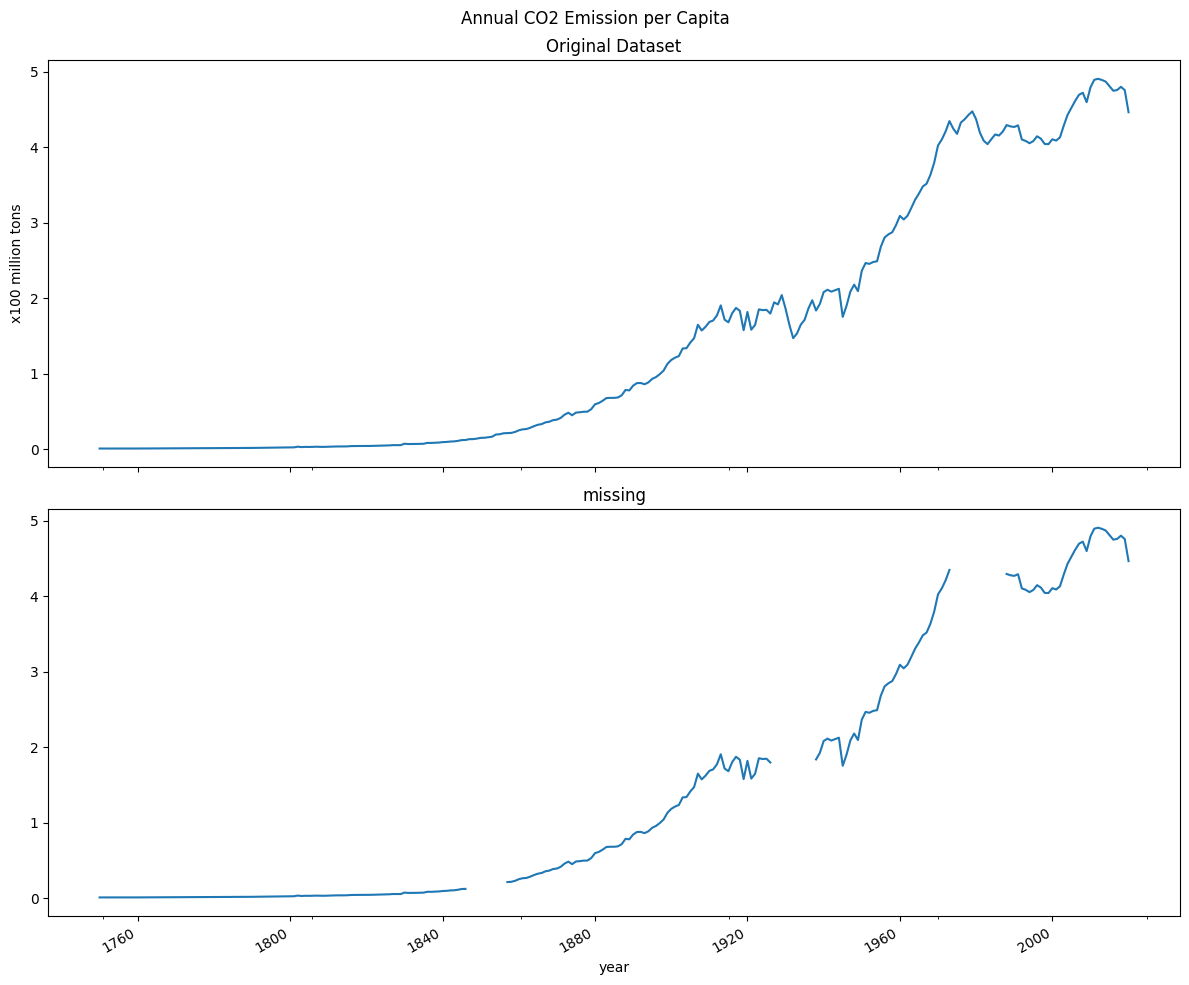

In [13]:
plot_dfs(co2_original, 
         co2_missing, 
         'co2',
         title="Annual CO2 Emission per Capita",
         xlabel="Years",
         ylabel="x100 million tons")

## Visualizing Original vs. Missing Data

The `plot_dfs()` function creates comparative plots between the original data and data with missing values. This visualization helps us understand:

1. The overall pattern and trend in the original data
2. Where the missing values are located
3. How the gaps in data might affect our analysis

Let's start by visualizing the CO2 emissions dataset:

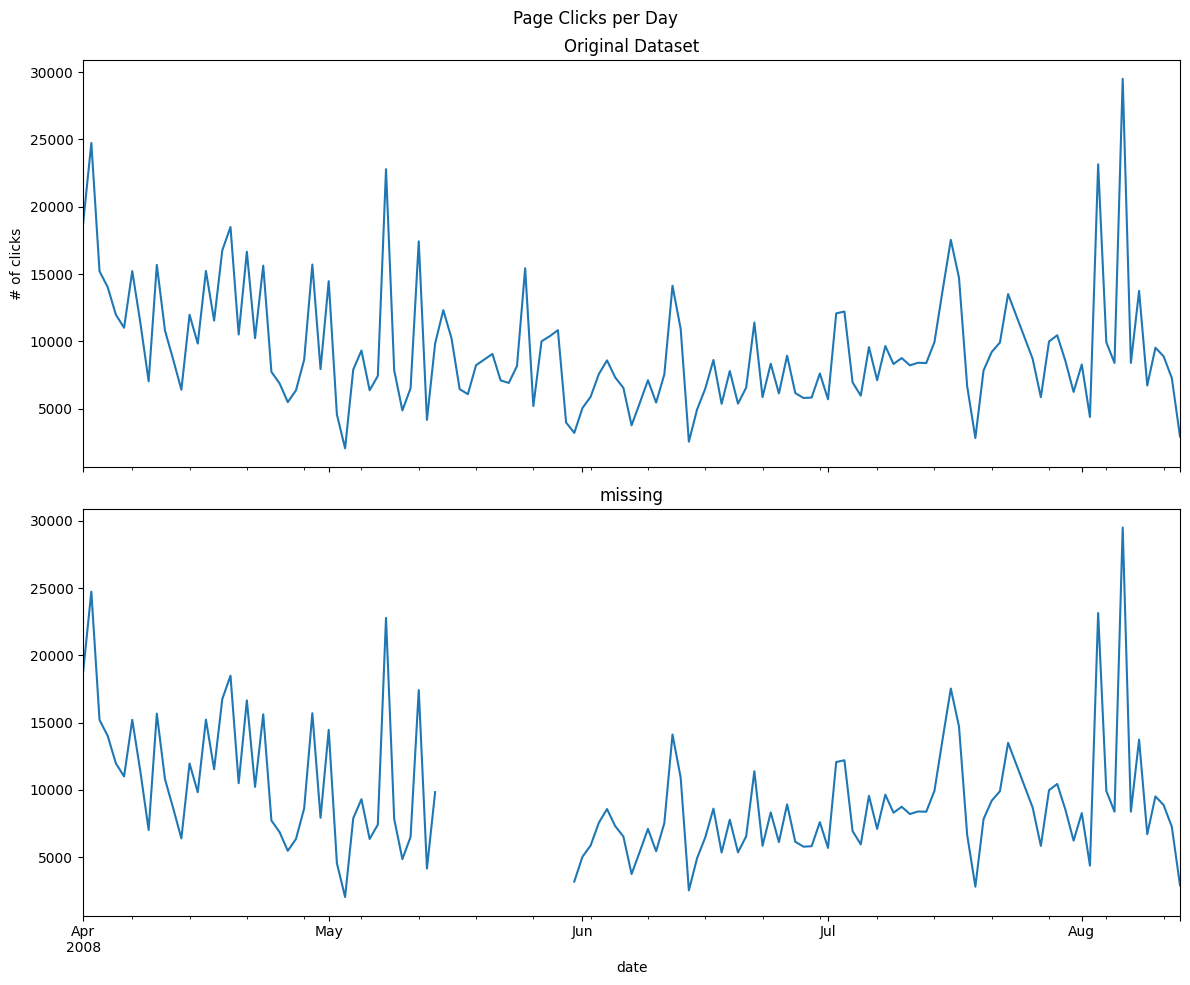

In [14]:
plot_dfs(clicks_original, 
         clicks_missing, 
         'clicks',
         title="Page Clicks per Day",
         xlabel="date",
         ylabel="# of clicks")

Now let's visualize the clickstream dataset to understand its pattern and missing values:

In this dataset, we can observe different characteristics compared to the CO2 dataset. The clickstream data shows more variability and may not exhibit the same clear trends we saw in the CO2 data.

In [18]:
co2_missing['ffill'] = co2_missing['co2'].ffill()
co2_missing['bfill'] = co2_missing['co2'].bfill()
co2_missing['mean'] = co2_missing['co2'].fillna(co2_missing['co2'].mean())

## Imputing Missing Values in CO2 Dataset

Now we'll apply three different univariate imputation techniques to the CO2 dataset:

1. **Forward Fill (ffill)**: Propagates the last valid observation forward to fill gaps
2. **Backward Fill (bfill)**: Propagates the next valid observation backward to fill gaps
3. **Mean Imputation**: Replaces missing values with the mean of the column

For time series data with trends (like our CO2 dataset), forward and backward fill often preserve the temporal patterns better than mean imputation.

In [19]:
_ = rmse_score(co2_original, 
                    co2_missing, 
                    'co2')

RMSE for ffill: 0.05873012599267133
RMSE for bfill: 0.05550012995280968
RMSE for mean: 0.7156383637041684


## Evaluating CO2 Imputation Methods

To evaluate the quality of our imputations, we'll use the Root Mean Square Error (RMSE) to compare each imputation method against the original data. RMSE measures the average magnitude of the errors, with lower values indicating better performance.

Let's calculate the RMSE for each method:

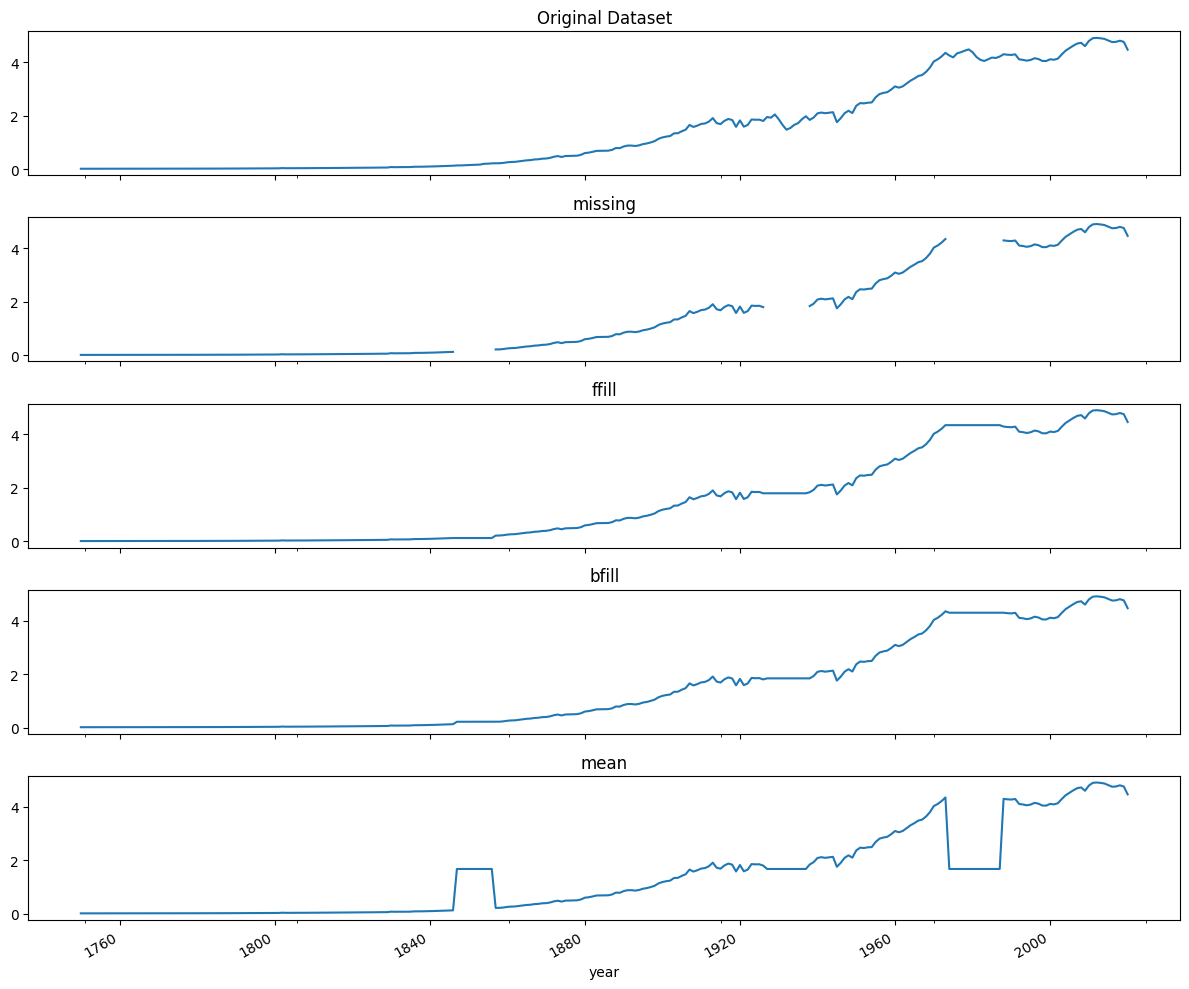

In [20]:
plot_dfs(co2_original, co2_missing, 'co2')

## Visualizing CO2 Imputation Results

Let's visualize the imputed values alongside the original data to better understand how each method performs:

For the CO2 dataset, we can observe that:
- Forward and backward fill maintain the trend of the dataset
- Mean imputation creates unrealistic flat lines that don't follow the data trend
- Based on the RMSE scores, backward fill performs slightly better than forward fill
- This is likely because backward fill leverages future observations that align more closely with the missing values, preserving the overall upward trend

In [21]:
clicks_missing['ffill'] = clicks_missing['clicks'].ffill()
clicks_missing['bfill'] = clicks_missing['clicks'].bfill()
clicks_missing['mean'] = clicks_missing['clicks'].fillna(clicks_missing['clicks'].mean())

## Imputing Missing Values in Clickstream Dataset

Now let's apply the same imputation methods to our clickstream dataset:
1. Forward Fill
2. Backward Fill
3. Mean Imputation

For clickstream data, which tends to be more volatile and less trend-dependent than CO2 emissions, different imputation methods may perform better.

In [22]:
_ = rmse_score(clicks_original, 
                    clicks_missing, 
                    'clicks')

RMSE for ffill: 1034.1210689204554
RMSE for bfill: 2116.6840489225033
RMSE for mean: 997.7600138929953


## Evaluating Clickstream Imputation Methods

Now let's calculate the RMSE for each imputation method on the clickstream dataset:

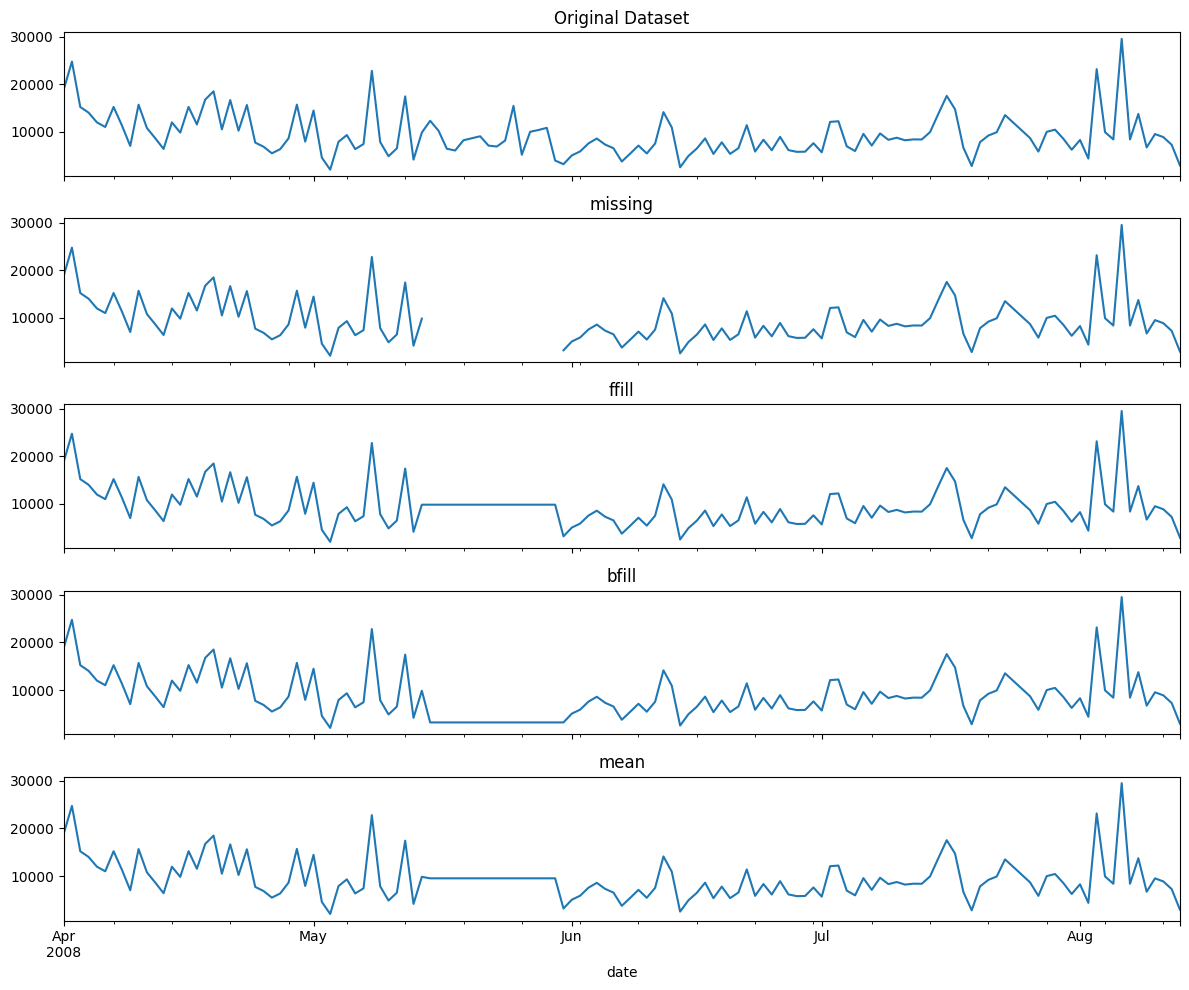

In [23]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

## Visualizing Clickstream Imputation Results

Let's visualize the imputed values for the clickstream dataset:

Interestingly, for the clickstream dataset:
- Mean imputation has the lowest RMSE score (unlike with the CO2 dataset)
- This is likely because clickstream data doesn't exhibit strong trends, making the mean a simple yet effective choice
- Forward and backward fill may introduce more bias by carrying values across longer gaps in this more volatile dataset

In [24]:
clicks_missing.loc['2008-05-10':'2008-05-18']

,price,location,clicks,ffill,bfill,mean
date,,,,,,
2008-05-10,42.576299,1,4863.0,4863.0,4863.0,4863.000000
2008-05-11,43.405890,5,6511.0,6511.0,6511.0,6511.000000
2008-05-12,43.258326,2,17426.0,17426.0,17426.0,17426.000000
2008-05-13,42.714479,2,4160.0,4160.0,4160.0,4160.000000
2008-05-14,43.372786,5,9841.0,9841.0,9841.0,9841.000000
2008-05-15,42.517755,2,NaN,9841.0,3194.0,9530.336134
2008-05-16,44.011009,2,NaN,9841.0,3194.0,9530.336134
2008-05-17,42.530303,2,NaN,9841.0,3194.0,9530.336134
2008-05-18,42.565698,5,NaN,9841.0,3194.0,9530.336134


## Examining Specific Date Ranges with Missing Values

Let's look at specific date ranges in our clickstream data to better understand the pattern of missing values and how our imputation methods handled them:

In [25]:
clicks_missing.loc['2008-05-30':'2008-06-15']

,price,location,clicks,ffill,bfill,mean
date,,,,,,
2008-05-30,44.558011,5,NaN,9841.0,3194.0,9530.336134
2008-05-31,43.100427,2,3194.0,3194.0,3194.0,3194.000000
2008-06-01,42.875000,2,5038.0,5038.0,5038.0,5038.000000
2008-06-02,43.406951,2,5879.0,5879.0,5879.0,5879.000000
2008-06-03,42.957505,5,7563.0,7563.0,7563.0,7563.000000
2008-06-04,42.930399,2,8584.0,8584.0,8584.0,8584.000000
2008-06-05,42.801887,2,7315.0,7315.0,7315.0,7315.000000
2008-06-06,43.740476,2,6541.0,6541.0,6541.0,6541.000000
2008-06-07,43.823729,1,3755.0,3755.0,3755.0,3755.000000


In [26]:
clicks_missing[clicks_missing['clicks'].isna()]

,price,location,clicks,ffill,bfill,mean
date,,,,,,
2008-05-15,42.517755,2,NaN,9841.0,3194.0,9530.336134
2008-05-16,44.011009,2,NaN,9841.0,3194.0,9530.336134
2008-05-17,42.530303,2,NaN,9841.0,3194.0,9530.336134
2008-05-18,42.565698,5,NaN,9841.0,3194.0,9530.336134
2008-05-19,43.892996,2,NaN,9841.0,3194.0,9530.336134
2008-05-20,43.247706,2,NaN,9841.0,3194.0,9530.336134
2008-05-21,44.106289,1,NaN,9841.0,3194.0,9530.336134
2008-05-22,43.810714,1,NaN,9841.0,3194.0,9530.336134
2008-05-23,43.620802,1,NaN,9841.0,3194.0,9530.336134


## Advanced Imputation Techniques with Dictionaries and DataFrames

In addition to simple scalar imputation methods, pandas provides more flexible approaches for imputing missing values:

In [27]:
clicks_missing = read_dataset(folder, 'clicks_missing_more.csv', 'date', index=True)
clicks_missing.isna().sum()

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_5965/1306688869.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(folder / file,


price        5
location     6
clicks      16
dtype: int64

### Handling Multiple Columns with Different Strategies

Let's load a more complex dataset with missing values in multiple columns and check how many missing values we have:

In [68]:
clicks_missing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2008-04-01 to 2008-08-13
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     130 non-null    float64
 1   location  129 non-null    float64
 2   clicks    119 non-null    float64
dtypes: float64(3)
memory usage: 4.2 KB


In [69]:
type(clicks_missing['location'].mode())

pandas.core.series.Series

### Using a Dictionary for Column-Specific Imputation

We can use a dictionary to apply different imputation strategies to different columns. This is especially useful when:
- Different columns require different imputation approaches
- You want to apply domain-specific knowledge to each column
- Columns have different data types or distributions

The dictionary's keys are column names and values are the imputation values:

In [37]:
values = {'clicks': clicks_missing['clicks'].median(), 
         'price': clicks_missing['price'].mean(),
         'location': clicks_missing['location'].mode()[0]}

values

{'clicks': np.float64(8391.0),
 'price': np.float64(43.500693119307684),
 'location': np.float64(1.0)}

In [38]:
clicks_missing.fillna(value=values, inplace=True)
clicks_missing.isna().sum()

price       0
location    0
clicks      0
dtype: int64

### Using Another DataFrame for Imputation

Another powerful approach is using a reference DataFrame for imputation. This is useful when:
- You have a complete reference dataset with similar structure
- You want to maintain consistency between datasets
- You're doing incremental updates to a dataset

When using another DataFrame for imputation, pandas will fill missing values in the target DataFrame with corresponding values from the reference DataFrame based on index alignment:

In [39]:
clicks_missing = read_dataset(folder, 'clicks_missing_more.csv', 'date', index=True)
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date', index=True)

clicks_missing.fillna(value=clicks_original, inplace=True)
clicks_missing.isna().sum()

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_5965/1306688869.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(folder / file,


price       0
location    0
clicks      0
dtype: int64

## Summary of Step 2: Univariate Imputation with Pandas

In this section, we've explored various univariate imputation techniques using pandas:

1. **Basic Imputation Methods**:
   - Forward Fill (ffill) - Uses last valid observation
   - Backward Fill (bfill) - Uses next valid observation
   - Mean Imputation - Uses column mean

2. **Key Insights**:
   - Different datasets require different imputation strategies
   - For trending time series (CO2), forward and backward fill performed better
   - For more volatile data (clickstream), mean imputation was surprisingly effective
   - The effectiveness of each method depends on the data's temporal structure and patterns

3. **Advanced Techniques**:
   - Using dictionaries to apply different strategies to different columns
   - Using reference DataFrames to maintain consistency across datasets

4. **Evaluation Approach**:
   - Visualizing results to understand imputation quality
   - Using RMSE to quantitatively compare methods against ground truth

The best imputation method depends on your specific dataset and the nature of the missing data. Always consider the data's characteristics and perform evaluation to select the most appropriate technique.

# Step 3: Handling Missing Data with Univariate Imputation using Scikit-Learn

Scikit-learn provides the `SimpleImputer` class, which offers a more structured and machine learning-oriented approach to handling missing values compared to pandas' built-in methods.

In this section, we'll explore:

* How to use `SimpleImputer` with different strategies (mean, median, most frequent)
* The workflow of fitting and transforming data
* How to prepare data for scikit-learn's imputation (reshaping to 2D arrays)
* How to evaluate and compare different imputation strategies
* Advanced features like adding missing indicators

The advantage of using scikit-learn's imputation tools is their seamless integration with machine learning pipelines and preprocessing workflows, making them particularly valuable when preparing data for predictive modeling.

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from pathlib import Path

## Setting Up the Environment and Loading Data

First, we'll import the necessary libraries including scikit-learn's `SimpleImputer` class, which is specifically designed for handling missing data in machine learning workflows. We'll then load the same four datasets we used previously:

In [ ]:
folder = Path('../data/')

co2_original = read_dataset(folder, 
                            'co2_original.csv', 'year', index=True)
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year', index=True)
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date', index=True)

In [43]:
strategy = [
    ('Mean Strategy', 'mean'),
    ('Median Strategy', 'median'),
    ('Most Frequent Strategy', 'most_frequent')
]

## Defining Imputation Strategies

The `SimpleImputer` class supports several strategies for imputation:

1. **Mean**: Replaces missing values with the mean of each column (default)
2. **Median**: Replaces missing values with the median of each column
3. **Most Frequent**: Replaces missing values with the most common value (mode)
4. **Constant**: Replaces missing values with a fixed value (requires specifying `fill_value`)

Let's create a list of tuples containing the strategy names and their corresponding parameter values:

## Using SimpleImputer with Different Strategies

First, let's define several imputation strategies and apply them to our datasets. We'll reshape our data as required by scikit-learn (which expects a 2D array) and apply each strategy:

In [44]:
co2_vals = co2_missing['co2'].values.reshape(-1,1)
clicks_vals = clicks_missing['clicks'].values.reshape(-1,1)

for s_name, s in strategy:
    co2_missing[s_name] = (
        SimpleImputer(missing_values=pd.NA, 
                      strategy=s).fit_transform(co2_vals))
    clicks_missing[s_name] = (
        SimpleImputer(missing_values=pd.NA, 
                      strategy=s).fit_transform(clicks_vals))

## Preparing Data for SimpleImputer

Scikit-learn's `SimpleImputer` requires input data in a 2D array format (a matrix). However, our data columns are 1D pandas Series objects. To convert them properly:

1. We extract the values from our pandas Series using `.values`
2. We reshape these 1D arrays into 2D column vectors using `.reshape(-1, 1)`

The reshape parameter `-1` automatically calculates the appropriate dimension based on the length of the array, and `1` specifies that we want 1 column. This transforms our data from shape `(n,)` to `(n, 1)`, where `n` is the number of rows.

After preparing the data, we'll apply each imputation strategy to both datasets:

In [45]:
_ = rmse_score(co2_original, co2_missing, 'co2')

RMSE for Mean Strategy: 0.7156383637041684
RMSE for Median Strategy: 0.802942160685986
RMSE for Most Frequent Strategy: 1.1245663822743381


## Evaluating CO2 Imputation Strategies

To evaluate the quality of our imputations, we'll calculate the Root Mean Square Error (RMSE) between the original values and our imputed values. Lower RMSE values indicate better performance.

Let's start by evaluating the imputation strategies on the CO2 dataset:

## Evaluating Imputation Strategies

To evaluate the quality of our imputations, we'll calculate the Root Mean Square Error (RMSE) between the original data and our imputed values. Lower RMSE indicates better performance:

In [46]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for Mean Strategy: 997.7600138929953
RMSE for Median Strategy: 959.3580492530756
RMSE for Most Frequent Strategy: 1097.6425985146868


## Evaluating Clickstream Imputation Strategies

Now let's evaluate the imputation strategies on the clickstream dataset:

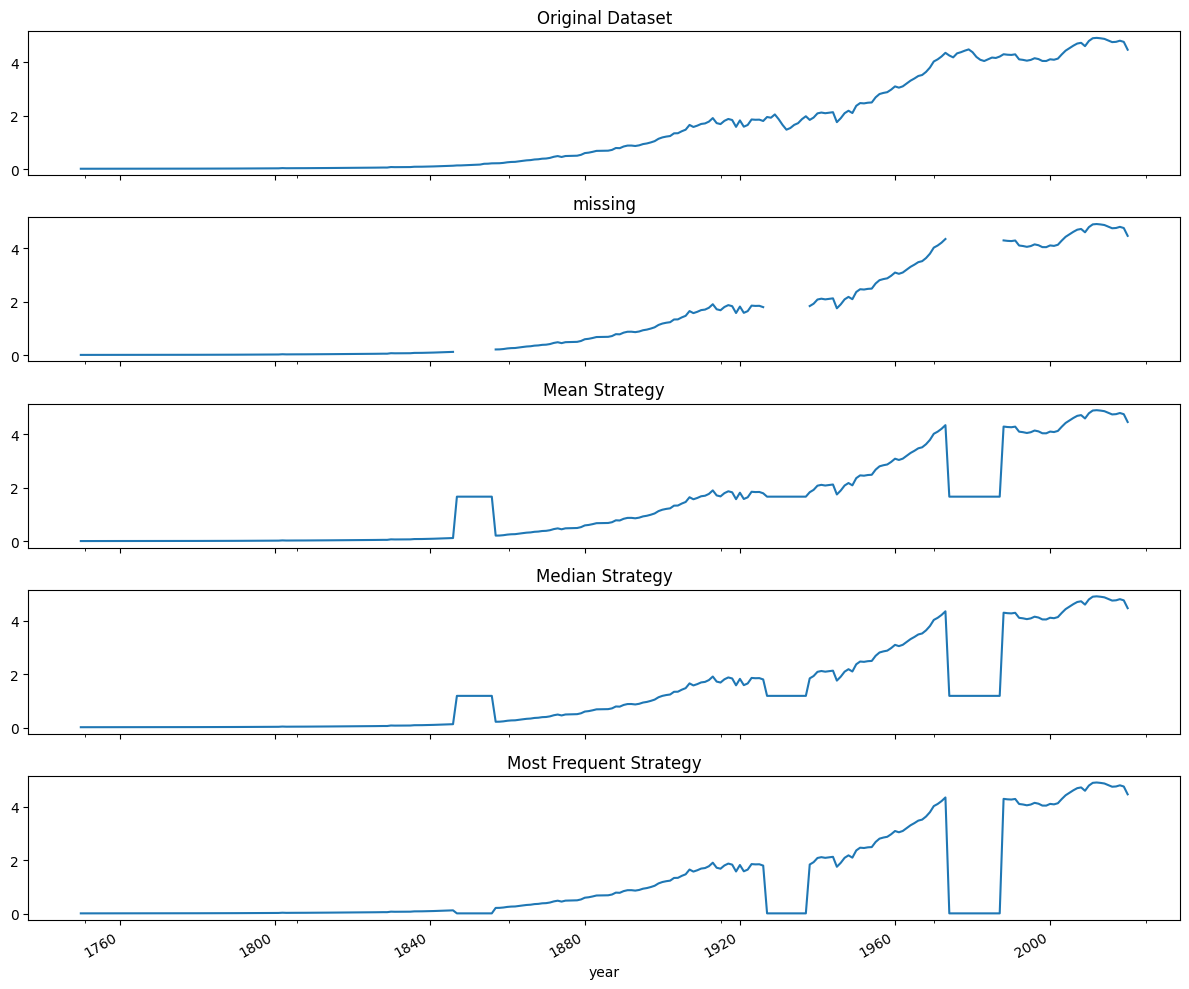

In [47]:
plot_dfs(co2_original, co2_missing, 'co2')

## Visualizing CO2 Imputation Results

To better understand how each strategy performs, let's visualize the imputed values alongside the original data for the CO2 dataset:

From the RMSE scores and visualization, we can observe:
- The mean strategy performs best for the CO2 dataset, likely because it better captures the overall trend
- The most frequent strategy has the highest RMSE, suggesting it doesn't work well for this continuously distributed data
- The median strategy falls between the two in terms of performance

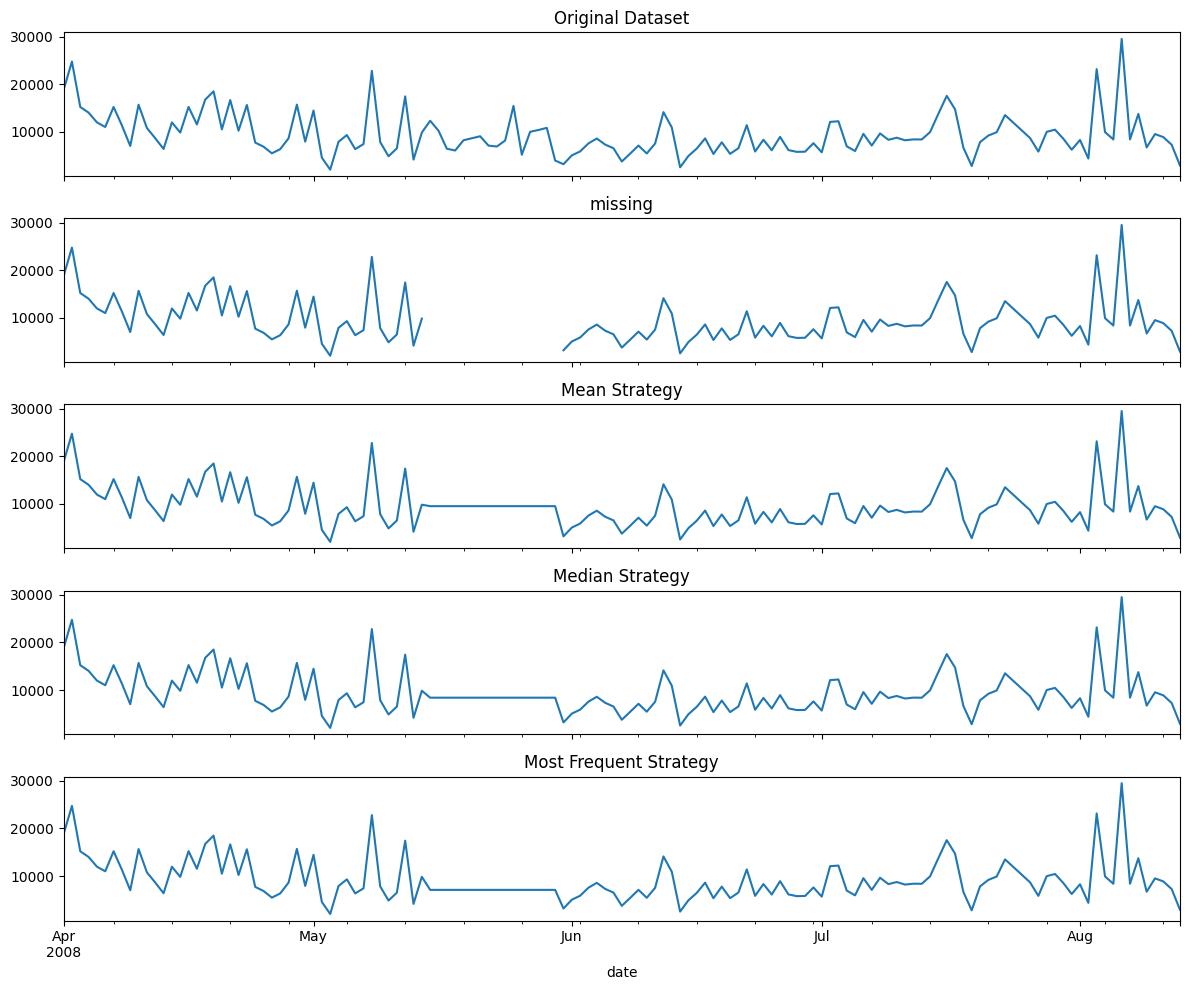

In [48]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

## Visualizing Clickstream Imputation Results

Now let's visualize the imputation results for the clickstream dataset:

Interestingly, for the clickstream dataset:
- The median strategy performs best, likely because it's less influenced by extreme values
- The most frequent strategy again has the highest RMSE
- The mean strategy performs better than most frequent but not as well as median

This highlights how different datasets may benefit from different imputation strategies based on their distribution and patterns.

In [49]:
avg = co2_missing['co2'].mean()
co2_missing['pandas_fillna'] = co2_missing['co2'].fillna(avg)

## Comparing Scikit-learn and Pandas Imputation

Let's compare the results from scikit-learn's `SimpleImputer` with pandas' `.fillna()` method using the mean imputation strategy. We should expect identical results since they're implementing the same mathematical operation:

In [50]:
co2_missing

,co2,Mean Strategy,Median Strategy,Most Frequent Strategy,pandas_fillna
year,,,,,
1750-01-01,0.0125,0.0125,0.0125,0.0125,0.0125
1760-01-01,0.0128,0.0128,0.0128,0.0128,0.0128
1770-01-01,0.0150,0.0150,0.0150,0.0150,0.0150
1780-01-01,0.0169,0.0169,0.0169,0.0169,0.0169
1790-01-01,0.0206,0.0206,0.0206,0.0206,0.0206
...,...,...,...,...,...
2016-01-01,4.7496,4.7496,4.7496,4.7496,4.7496
2017-01-01,4.7595,4.7595,4.7595,4.7595,4.7595
2018-01-01,4.8022,4.8022,4.8022,4.8022,4.8022


In [51]:
cols = ['co2', 'Mean Strategy', 'pandas_fillna']
_ = rmse_score(co2_original, co2_missing[cols], 'co2')

RMSE for Mean Strategy: 0.7156383637041684
RMSE for pandas_fillna: 0.7156383637041684


In [52]:
pd.Series([pd.NA])

0    <NA>
dtype: object

## Understanding Missing Value Representations

Both pandas and scikit-learn support different representations of missing values. Let's explore how pandas represents missing values:

In [53]:
pd.Series([np.nan])

0   NaN
dtype: float64

In [54]:
import pandas as pd
import numpy as np

data = {
    'A': [1, 2, np.nan, 4],
    'B': [np.nan, 2, 3, 4],
    'C': [1, np.nan, np.nan, 4]
}
sales_report_data = pd.DataFrame(data)
print(sales_report_data)

     A    B    C
0  1.0  NaN  1.0
1  2.0  2.0  NaN
2  NaN  3.0  NaN
3  4.0  4.0  4.0


## Handling Multiple Columns with Pandas

While scikit-learn's `SimpleImputer` requires reshaping and handling one column at a time (unless they share the same imputation strategy), pandas provides a more straightforward approach for imputing across multiple columns simultaneously.

Let's create a sample DataFrame with missing values in multiple columns and apply mean imputation:

In [55]:
sales_report_data.fillna(sales_report_data.mean(), inplace=True)
print(sales_report_data)

          A    B    C
0  1.000000  3.0  1.0
1  2.000000  2.0  2.5
2  2.333333  3.0  2.5
3  4.000000  4.0  4.0


## Advanced Feature: Missing Indicators

Scikit-learn's `SimpleImputer` offers an advanced feature called `add_indicator` that can enhance your imputation process. When set to `True`, this option adds a binary indicator column that flags whether a value was originally missing (1) or observed (0).

This feature is particularly valuable when:
1. The pattern of missingness itself contains important information
2. You want to track which values were imputed in downstream analysis
3. You're building machine learning models where the absence of data might be meaningful

Let's demonstrate how to use this feature:

In [56]:
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year', index=True)
co2_vals = co2_missing['co2'].values.reshape(-1,1)


### Setting Up the SimpleImputer with Indicators

First, let's reload our dataset and initialize a `SimpleImputer` with the `add_indicator` parameter set to `True`:

In [57]:
imputer = SimpleImputer(strategy='mean', add_indicator=True)

### Creating the Imputer with Indicator Flag

We'll create an imputer with mean strategy and enable the indicator feature:

In [58]:
imputer.fit(co2_vals)

,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,True
,keep_empty_features,False


### Fitting the Imputer to Our Data

After creating the imputer, we need to fit it to our data. This calculates the statistics (in this case, the mean) needed for imputation:

In [59]:
imputer.get_params()

{'add_indicator': True,
 'copy': True,
 'fill_value': None,
 'keep_empty_features': False,
 'missing_values': nan,
 'strategy': 'mean'}

### Examining Imputer Parameters

Let's check the parameters of our fitted imputer to confirm our configuration:

In [92]:
imputer.indicator_

,missing_values,nan
,features,'missing-only'
,sparse,'auto'
,error_on_new,False


### Checking the Indicator Feature

The `indicator_` attribute confirms that our imputer has created a missing indicator transformer:

In [60]:
co2_missing[['imputed', 'indicator']] = (imputer.transform(co2_vals))
print(co2_missing.head(5))

               co2  imputed  indicator
year                                  
1750-01-01  0.0125   0.0125        0.0
1760-01-01  0.0128   0.0128        0.0
1770-01-01  0.0150   0.0150        0.0
1780-01-01  0.0169   0.0169        0.0
1790-01-01  0.0206   0.0206        0.0


### Applying the Transformation with Indicators

Now we'll apply the transformation to our data. The output will include both:
1. The imputed values
2. A binary indicator column (1 = missing, 0 = observed)

Let's add these columns to our DataFrame and examine the results:

In [ ]:
print(co2_missing.loc['1855-01-01':].head())

               co2   imputed  indicator
year                                   
1855-01-01     NaN  1.673262        1.0
1856-01-01     NaN  1.673262        1.0
1857-01-01  0.2163  0.216300        0.0
1858-01-01  0.2192  0.219200        0.0
1859-01-01  0.2320  0.232000        0.0


### Examining the Indicator in Action

Let's look at specific rows to see how the indicator works:

In the output:
- The `co2` column shows original values with `NaN` for missing data
- The `imputed` column contains all values, with the mean filling in where data was missing
- The `indicator` column shows `1.0` where values were missing and `0.0` where they were observed

This pattern of missingness can be valuable information for further analysis or modeling. For example, if missing values occur in specific time periods or under particular conditions, this pattern itself might be predictive.

## Summary of Step 3: Univariate Imputation with Scikit-learn

In this section, we explored scikit-learn's `SimpleImputer` for handling missing data:

1. **Core Imputation Strategies**:
   - Mean imputation - Replaces missing values with column mean
   - Median imputation - Replaces missing values with column median
   - Most frequent imputation - Replaces missing values with most common value

2. **Key Insights**:
   - Different strategies work better for different datasets
   - For CO2 data, mean imputation performed best
   - For clickstream data, median imputation was most effective
   - Most frequent imputation generally performed poorly on continuous data

3. **Advanced Features**:
   - The `add_indicator` parameter creates binary flags for missing values
   - This pattern of missingness can be valuable information for analysis and modeling

4. **Workflow Considerations**:
   - Scikit-learn requires reshaping data to 2D arrays
   - The standard workflow involves `fit` then `transform` (or `fit_transform` for convenience)
   - Integration with scikit-learn's preprocessing and machine learning pipelines is seamless

5. **Comparison with Pandas**:
   - Scikit-learn and pandas produce identical results for equivalent strategies
   - Pandas is more convenient for simple operations or when working with multiple columns
   - Scikit-learn shines in machine learning workflows and offers more specialized features

The choice between pandas and scikit-learn for imputation depends on your broader workflow. For data exploration and simple imputation, pandas may be sufficient. For machine learning pipelines or more complex preprocessing needs, scikit-learn offers better integration and specialized features.

# Step 4: Handling Missing Data with Multivariate Imputation

While univariate imputation methods consider each variable independently, **multivariate imputation** techniques leverage relationships between variables to generate more accurate estimations for missing values. This is particularly valuable when variables in a dataset are correlated.

In this section, we'll explore two powerful multivariate imputation tools from scikit-learn:

1. **IterativeImputer**: Models each feature with missing values as a function of other features through an iterative process (similar to MICE - Multivariate Imputation by Chained Equations)
2. **KNNImputer**: Uses k-nearest neighbors to estimate missing values based on similar data points

For multivariate imputation to be effective, there should be meaningful relationships between variables. The clickstream dataset is well-suited for this approach since variables like price, location, and clicks likely have interdependencies.

## How Multivariate Imputation Works

Multivariate imputation offers several advantages over univariate methods:

- It leverages correlations between variables to make more informed predictions
- It can capture complex relationships that simple methods like mean or median imputation cannot
- It often produces more realistic imputations that preserve the natural variability of the data

The two main approaches we'll explore are:

1. **Iterative Imputation (MICE)**: Works by modeling each feature with missing values as a function of other features in a round-robin fashion. It proceeds through multiple iterations until convergence.

2. **K-Nearest Neighbors Imputation**: Estimates missing values by finding the k most similar samples in the feature space and averaging their values.

In [65]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# We need to explicitly enable the experimental IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Various regressors that can be used with IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import (ElasticNet, 
                                  LinearRegression, 
                                  BayesianRidge)
from sklearn.neighbors import KNeighborsRegressor

## Setting Up the Environment for Multivariate Imputation

We'll start by importing the necessary libraries:

1. `enable_iterative_imputer` from sklearn.experimental - Required to use the experimental IterativeImputer class
2. `IterativeImputer` - For iterative multivariate imputation
3. Various regressors that will serve as estimators:
   - Ensemble methods: ExtraTreesRegressor, BaggingRegressor
   - Linear models: ElasticNet, LinearRegression, BayesianRidge
   - Instance-based methods: KNeighborsRegressor

In [ ]:
folder = Path('../data/')

clicks_original = read_dataset(folder, 
                            'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 
                            'clicks_missing.csv', 'date', index=True)

## How IterativeImputer Works

The IterativeImputer class from scikit-learn is inspired by the R MICE package (Multivariate Imputation by Chained Equations), a well-known implementation for imputing missing data. Here's how it works:

1. **Initial Imputation**: Start by filling missing values with simple estimates (e.g., mean).

2. **Iterative Process**:
   - For each feature with missing values, treat it as the dependent variable
   - Use all other features as independent variables to build a predictive model
   - Use that model to predict and update the missing values
   - Move to the next feature with missing values and repeat
   - Continue this cycle for multiple iterations until the values converge

3. **Regressor Selection**: The choice of regression algorithm can significantly impact the results:
   - **BayesianRidge**: A regression model that uses Bayesian inference to estimate coefficient distributions, helping with multicollinearity and providing uncertainty estimates.
   - **ExtraTreesRegressor**: An ensemble of randomized decision trees that helps reduce overfitting.
   - **BaggingRegressor**: Combines predictions from multiple base regressors to improve stability and accuracy.
   - **ElasticNet**: Combines L1 (Lasso) and L2 (Ridge) regularization to handle correlated features.
   - **LinearRegression**: A simple linear model that fits a linear relationship between features and target.
   - **KNeighborsRegressor**: Predicts based on the average of k-nearest neighbors in feature space.

While Scikit-Learn's IterativeImputer typically returns a single imputation, the MICE algorithm in R is designed to produce multiple imputations to account for the uncertainty in the missing value estimates.

## Loading the Datasets

For multivariate imputation, we'll focus on the clickstream dataset since it has multiple variables (clicks, price, location) that can be used to predict missing values. We'll load both the original dataset (without missing values) and the version with missing values:

In [67]:
clicks_missing.isna().sum()

price        0
location     0
clicks      16
dtype: int64

## Using IterativeImputer

The `IterativeImputer` class from scikit-learn is inspired by the R MICE package (Multivariate Imputation by Chained Equations), a well-established implementation for imputing missing data.

How it works:
1. Each feature with missing values is modeled as a function of other features
2. The process continues iteratively until convergence
3. You can specify different regression models as the `estimator` parameter

One major advantage of `IterativeImputer` is its flexibility in allowing different regressors to be used as estimators. This lets us test various algorithms to see which performs best for our specific dataset.

In [68]:
# Create a list of regressors to evaluate with IterativeImputer
regressors = [
    ('bayesianRidge', BayesianRidge()),
    ('extra_trees', ExtraTreesRegressor(n_estimators=50, random_state=42)),
    ('bagging', BaggingRegressor(n_estimators=50, random_state=42)),
    ('elastic_net', ElasticNet()),
    ('linear_regression', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=3))
]

# Each regressor has different strengths:
# - BayesianRidge: Good for handling multicollinearity, provides uncertainty estimates
# - ExtraTreesRegressor: Ensemble method that reduces overfitting with randomized decision trees
# - BaggingRegressor: Improves stability by combining multiple base models
# - ElasticNet: Combines L1 and L2 regularization to handle correlated features
# - LinearRegression: Simple linear model that's fast but assumes linear relationships
# - KNeighborsRegressor: Instance-based learning that performs well with local patterns

In [69]:
# Extract the columns we need for imputation (price, location, clicks)
clicks_vals = clicks_missing.iloc[:,0:3].to_numpy()

# Loop through each regressor to train and apply the imputation models
for reg_name, reg in regressors:
    # Create an IterativeImputer with the current regressor
    est = IterativeImputer(
                random_state=15,  # Setting a random state for reproducibility
                estimator=reg).fit(clicks_vals)  # Fit the imputer to our data
    
    # Transform the data and extract the imputed 'clicks' values (index 2)
    # Store the results in a new column named after the regressor
    clicks_missing[reg_name] = est.transform(clicks_vals)[: , 2]

In [70]:
# Calculate Root Mean Square Error (RMSE) for each regressor
# RMSE measures the average magnitude of the errors between predicted and actual values
# Lower RMSE values indicate better performance
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 949.4393973455849
RMSE for extra_trees: 1404.1501333341182
RMSE for bagging: 1265.5100992417892
RMSE for elastic_net: 945.4075209343101
RMSE for linear_regression: 938.9419831427186
RMSE for knn: 1336.8798392251822


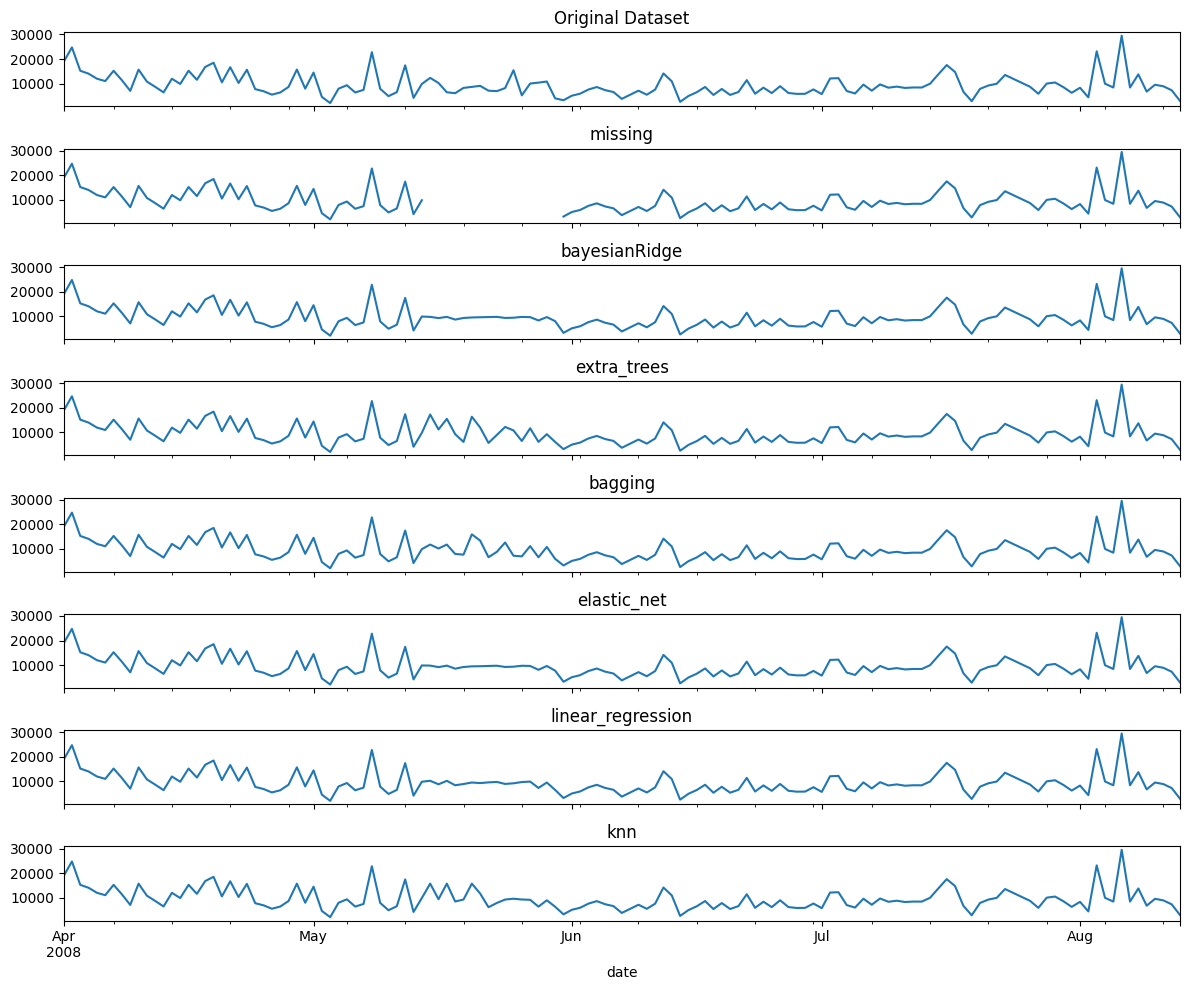

In [71]:
# Visualize the imputed values for all regressors
# This helps us see how each method performs across the dataset
# and better understand the strengths/weaknesses of each approach
plot_dfs(clicks_original, clicks_missing, 'clicks')

## Using KNNImputer

For an alternative approach to multivariate imputation, we can use the `KNNImputer` class from scikit-learn.

How it works:
- Finds the k-nearest neighbors to each sample with missing values
- Estimates missing values by averaging the non-missing values from those neighbors
- The neighbors are determined in feature space using a distance metric (default: Euclidean)

KNNImputer is particularly effective when:
- The data has local patterns or clusters
- Missing values are similar to their neighbors
- The dataset doesn't have a strong global structure that other regressors can capture

Unlike the IterativeImputer, KNNImputer uses a non-iterative approach and relies on local information from neighboring samples rather than building predictive models for each feature.

In [72]:
# Import KNNImputer from scikit-learn
from sklearn.impute import KNNImputer

# Create a KNNImputer with 3 neighbors
# The n_neighbors parameter controls how many neighbors are used to estimate each missing value
knn_imputer = KNNImputer(n_neighbors=3)

# Apply the imputer to our data and extract the 'clicks' column (index 2)
# Store the results in a new column called 'knn_imputer'
clicks_missing['knn_imputer'] = knn_imputer.fit_transform(clicks_vals)[: , 2]

## Comparing KNN-Based Methods

An interesting comparison is between KNNImputer and IterativeImputer with KNeighborsRegressor as its estimator. While both use the k-nearest neighbors algorithm, they apply it differently:

### KNNImputer:
- **Direct approach**: Finds k-nearest neighbors for samples with missing values and uses their values directly
- **Non-iterative**: Performs imputation in a single step without iterations
- **Local perspective**: Only considers the local neighborhood of each sample with missing values
- **Implementation**: Specialized for missing value imputation

### IterativeImputer with KNeighborsRegressor:
- **Model-based approach**: Uses KNN as a regression model within an iterative framework
- **Iterative process**: Updates imputations across multiple iterations until convergence
- **Global perspective**: Considers relationships across all features through the iterative process
- **Implementation**: More general framework that can use any regression algorithm

These different approaches can lead to different results even though they both use the same underlying KNN concept. The optimal choice depends on:
1. The structure and patterns in your data
2. The amount and distribution of missing values
3. The relationships between variables in your dataset

In [103]:
clicks_missing

,price,location,clicks,bayesianRidge,extra_trees,bagging,elastic_net,linear_regression,knn,knn_imputer
date,,,,,,,,,,
2008-04-01,43.155647,2,18784.0,18784.0,18784.0,18784.0,18784.0,18784.0,18784.0,18784.0
2008-04-02,43.079056,1,24738.0,24738.0,24738.0,24738.0,24738.0,24738.0,24738.0,24738.0
2008-04-03,43.842609,2,15209.0,15209.0,15209.0,15209.0,15209.0,15209.0,15209.0,15209.0
2008-04-04,43.312376,1,14018.0,14018.0,14018.0,14018.0,14018.0,14018.0,14018.0,14018.0
2008-04-05,43.941176,1,11974.0,11974.0,11974.0,11974.0,11974.0,11974.0,11974.0,11974.0
...,...,...,...,...,...,...,...,...,...,...
2008-08-09,44.182033,1,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0
2008-08-10,43.608260,1,9523.0,9523.0,9523.0,9523.0,9523.0,9523.0,9523.0,9523.0
2008-08-11,43.553363,1,8881.0,8881.0,8881.0,8881.0,8881.0,8881.0,8881.0,8881.0


In [73]:
# Re-calculate the RMSE scores after adding the KNNImputer results
# This shows us how the standalone KNNImputer compares to the various regressors
# used with IterativeImputer
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 949.4393973455849
RMSE for extra_trees: 1404.1501333341182
RMSE for bagging: 1265.5100992417892
RMSE for elastic_net: 945.4075209343101
RMSE for linear_regression: 938.9419831427186
RMSE for knn: 1336.8798392251822
RMSE for knn_imputer: 1336.8798392251822


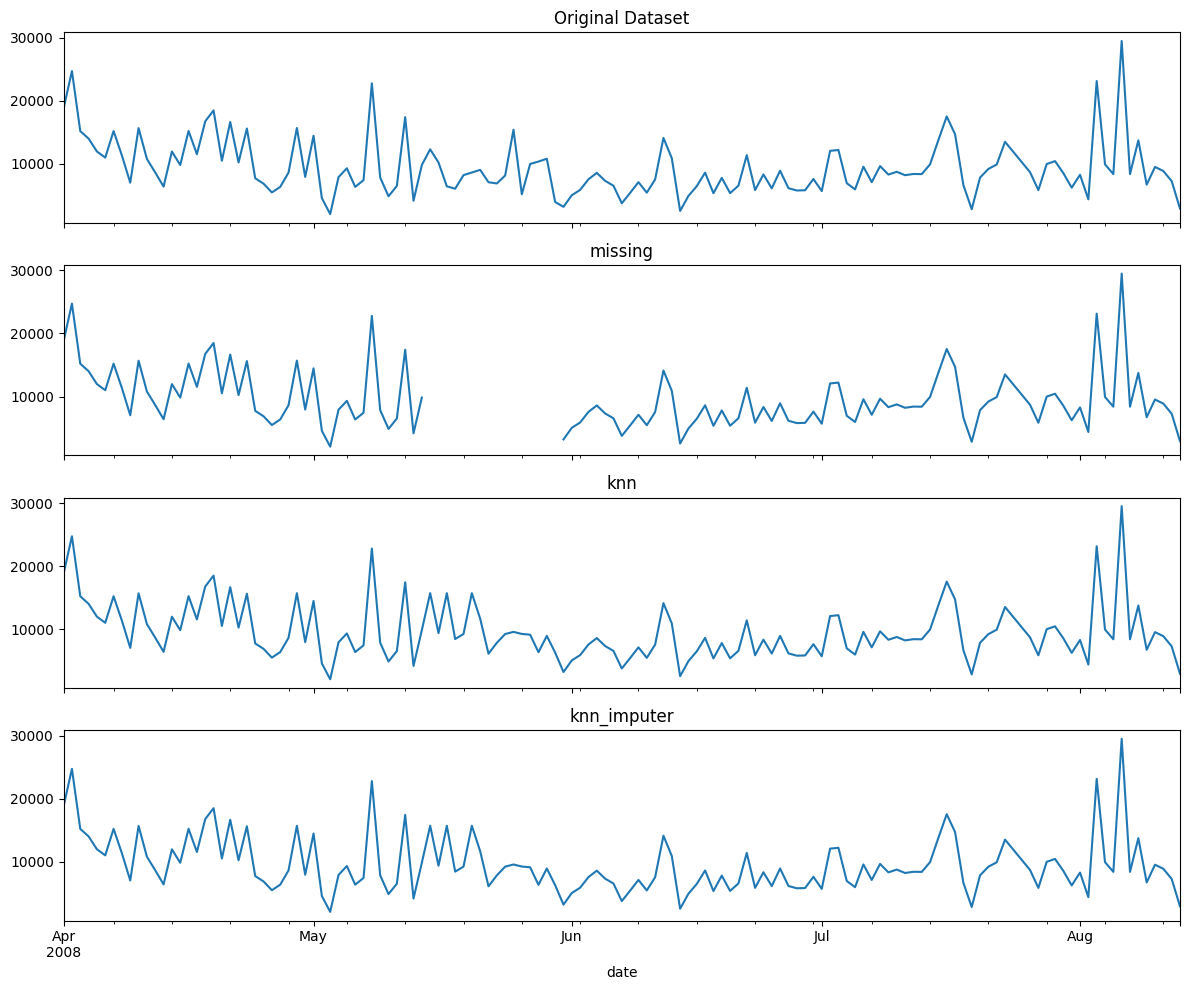

In [74]:
# Compare the results from KNNImputer with IterativeImputer using KNeighborsRegressor
# This is an interesting comparison because both use K-nearest neighbors but in different ways:
# - KNN via IterativeImputer uses KNN within an iterative modeling process
# - KNNImputer directly uses KNN to find similar samples for imputation
plot_dfs(clicks_original, clicks_missing[['clicks','knn','knn_imputer']], 'clicks')

## Understanding the Results and Trade-offs

From our experiments with multivariate imputation techniques, we can observe several key insights:

1. **Comparison of Regression Models in IterativeImputer**:
   - BayesianRidge, ElasticNet, and LinearRegression typically produce similar results with lower RMSE scores
   - Tree-based methods like ExtraTreesRegressor and BaggingRegressor tend to have higher RMSE values but may capture more complex patterns
   - Different regressors perform differently depending on the underlying data distribution and relationships

2. **KNNImputer vs. IterativeImputer with KNeighborsRegressor**:
   - Despite using the same underlying KNN algorithm, these two approaches can produce different results
   - KNNImputer is non-iterative and uses local information directly from neighboring samples
   - IterativeImputer with KNeighborsRegressor builds predictive models for each feature iteratively

3. **When to Choose Each Approach**:
   - **KNNImputer**: Better for datasets with localized relationships where neighboring samples share similar values
   - **IterativeImputer**: Better for datasets where missing values depend on more complex relationships among multiple variables

4. **RMSE vs. Visual Assessment**:
   - While RMSE provides a quantitative measure of imputation quality, it doesn't tell the full story
   - Visual inspection helps us see if the imputed values maintain the natural variability and patterns of the original data
   - Some methods with lower RMSE might produce overly smooth imputations that don't capture the data's natural randomness

5. **Limitations to Consider**:
   - IterativeImputer is still in scikit-learn's experimental module, so its interface may change in future releases
   - Complex imputation methods may overfit to noise in the data
   - The quality of imputation depends heavily on how well the existing variables predict the missing ones

The best imputation approach depends on your specific dataset characteristics, the pattern of missingness, and your downstream analysis goals. It's always good practice to try multiple methods and evaluate them both quantitatively and qualitatively.

## Important Considerations When Using RMSE for Imputation Evaluation

While RMSE (Root Mean Square Error) is a valuable metric for comparing imputation methods, it has several limitations when evaluating imputation quality:

1. **RMSE Limitations**:
   - Lower RMSE doesn't always indicate a more "accurate" imputation in the real-world context
   - Some methods may produce the lowest RMSE but fail to capture the natural variability in the data
   - Methods like BayesianRidge, ElasticNet, and Linear Regression might yield lower RMSE values but could over-smooth the data

2. **Balance in Imputation**:
   - The goal of imputation is not necessarily achieving the "best" score (lowest RMSE)
   - Rather, it's filling missing data in a way that preserves the true nature and variability of the dataset
   - Some level of imperfection in imputed values is acceptable, as we often don't know the true nature of the missing data

3. **Visual Assessment**:
   - Always complement statistical metrics with visual inspection
   - Look for unrealistic patterns like flat lines or steps that don't match the data's natural behavior
   - Check if the imputed values preserve the overall trends and variance of the data

4. **Downstream Analysis**:
   - The ultimate test of imputation quality is how well it serves your downstream analysis
   - An imputation that works well for descriptive statistics might not be optimal for predictive modeling
   - Consider your analytical goals when choosing an imputation method

Remember that imputation is about creating a dataset that provides a "good enough" representation for your analytical needs, balancing accuracy with the preservation of natural data characteristics.

# Step 5: Handling Missing Data with Interpolation

Interpolation is especially useful for time series or sequential data where missing values can be reasonably estimated from surrounding observations. Unlike simple imputation methods, interpolation considers the position of data points to create a smooth transition between known values.

## How to Approach Interpolation

In this section, you'll perform multiple interpolations on two different datasets and then compare the results using RMSE and visualization to determine which provides the most accurate reconstructions of missing values.

We'll explore various interpolation methods using pandas' `.interpolate()` function:

* **Linear Interpolation**: Assumes a straight line between points (the default method)
* **Polynomial Interpolation**: Fits a polynomial of specified order through the data points
* **Spline Interpolation**: Uses piecewise polynomials for a smoother curve
* **Nearest Interpolation**: Uses the nearest non-missing value
* **Cubic Interpolation**: Fits a cubic spline for smoother transitions

Each method makes different assumptions about the underlying data patterns, so their performance will vary depending on your dataset's characteristics.

In [75]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

## Step 1: Loading the Datasets

Let's start by reading the CSV files into DataFrames. 
We'll need both the original datasets (without missing values) and the datasets with missing values to evaluate our interpolation methods.


In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

folder = Path('../data/')

co2_original = read_dataset(folder, 
                            'co2_original.csv', 'year', index=True)
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year', index=True)
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date', index=True)

## Understanding Pandas Interpolation

The `.interpolate()` method in pandas provides various techniques for estimating missing values based on patterns in the existing data. For a comprehensive list of available interpolation methods, you can reference the [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html).

Different methods work better for different types of data:
- Linear interpolation is ideal for datasets with consistent trends
- Spline and polynomial methods can capture more complex, non-linear patterns
- Nearest interpolation is useful when values change in discrete steps

Let's first see what happens with the basic interpolate method without parameters:

In [108]:
co2_missing.interpolate()

,co2
year,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206
...,...
2016-01-01,4.7496
2017-01-01,4.7595
2018-01-01,4.8022


## Step 2: Creating a List of Interpolation Methods to Test

Let's define a list of standard interpolation methods to test. We'll start with four common methods:
- `linear`: Assumes a straight line between points (default)
- `quadratic`: Fits a quadratic function (2nd degree polynomial) 
- `nearest`: Uses the value from the nearest non-missing point
- `cubic`: Uses a cubic spline (3rd degree polynomial) for smoother curves

Then we'll also test two additional methods that require an `order` parameter:
- `spline`: Creates a smoothed spline curve with the specified order
- `polynomial`: Fits a polynomial of the specified order

In [78]:
interpolations = [
    'linear',
    'quadratic',
    'nearest',
    'cubic'
]

for intp in interpolations:
    co2_missing[intp] = co2_missing['co2'].interpolate(method=intp)
    clicks_missing[intp] = clicks_missing['clicks'].interpolate(method=intp)


co2_missing['spline'] = \
    co2_missing['co2'].interpolate(method='spline', order=2)
co2_missing['polynomial'] = \
    co2_missing['co2'].interpolate(method='polynomial',order=2)


clicks_missing['spline'] = \
    clicks_missing['clicks'].interpolate(method='spline',order=2)
clicks_missing['polynomial'] = \
    clicks_missing['clicks'].interpolate(method='polynomial',order=2)

## Understanding the Order Parameter for Spline and Polynomial Interpolation

For the spline and polynomial methods, we need to specify an `order` parameter, which determines the complexity of the fitted curve:

- **Spline interpolation**: Creates piecewise polynomial functions that join smoothly at data points
- **Polynomial interpolation**: Fits a single polynomial function through all data points

For both methods, we've chosen `order=2` (quadratic) as a balanced choice:
- Higher orders (3+) can model more complex patterns but risk overfitting
- Lower orders (1) are essentially linear and may not capture curves well
- Order 2 provides a good balance for modeling smooth, non-linear patterns without excessive complexity

Now, let's evaluate how well each interpolation method performed using RMSE (Root Mean Square Error).

## Step 3: Evaluating Interpolation Methods for CO2 Data

Let's calculate the RMSE scores for each interpolation method applied to the CO2 dataset:

In [80]:
_ = rmse_score(co2_original, co2_missing, 'co2')

# Expected output similar to:
# RMSE for linear: 0.05507291327761665
# RMSE for quadratic: 0.08367561505614354
# RMSE for nearest: 0.05385422309469095
# RMSE for cubic: 0.08373627305833194
# RMSE for spline: 0.18786023475414115
# RMSE for polynomial: 0.08367561505614354

RMSE for linear: 0.05507291327761665
RMSE for quadratic: 0.08367561505614347
RMSE for nearest: 0.05385422309469095
RMSE for cubic: 0.08373627305833187
RMSE for spline: 0.18786023475414115
RMSE for polynomial: 0.08367561505614347


## Step 4: Evaluating Interpolation Methods for Clickstream Data

Now, let's calculate the RMSE scores for each interpolation method applied to the Clickstream dataset:

In [81]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

# Expected output similar to:
# RMSE for linear: 1329.1448378562811
# RMSE for quadratic: 5224.641260626975
# RMSE for nearest: 1706.1853705030173
# RMSE for cubic: 6199.304875782831
# RMSE for spline: 5222.9229934486475
# RMSE for polynomial: 5224.641260626975

RMSE for linear: 1329.1448378562811
RMSE for quadratic: 5224.641260626975
RMSE for nearest: 1706.1853705030173
RMSE for cubic: 6199.304875782831
RMSE for spline: 5222.9229934486475
RMSE for polynomial: 5224.641260626975


## Step 5: Visualizing CO2 Interpolation Results

Let's visualize how each interpolation method performed on the CO2 dataset. This will help us understand the differences between methods beyond what RMSE scores alone can tell us:

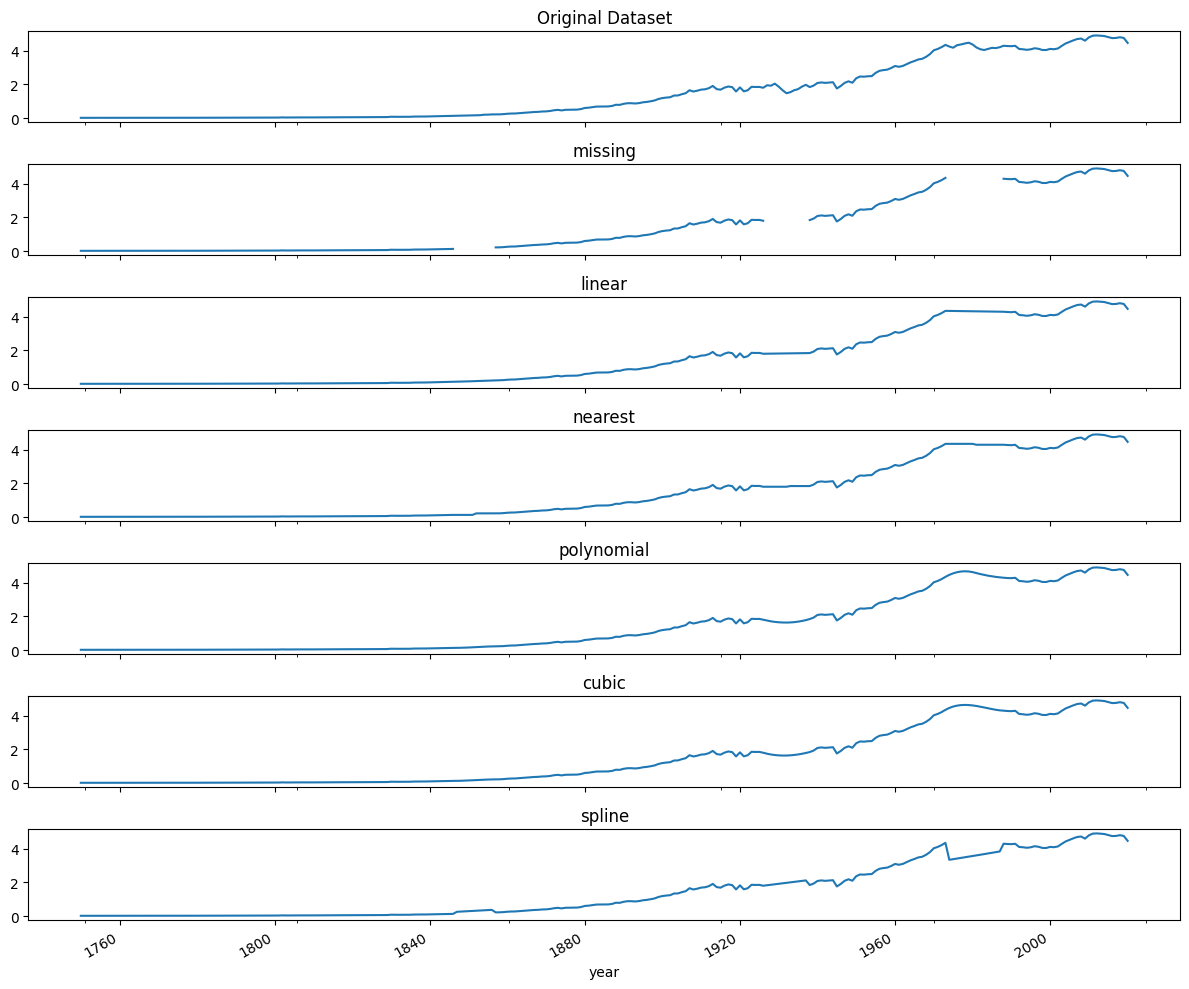

In [82]:

cols = ['co2', 'linear', 'nearest', 'polynomial', 'cubic', 'spline']
plot_dfs(co2_original, co2_missing[cols], 'co2')


## Step 6: Visualizing Clickstream Interpolation Results

Now, let's visualize how each interpolation method performed on the Clickstream dataset:

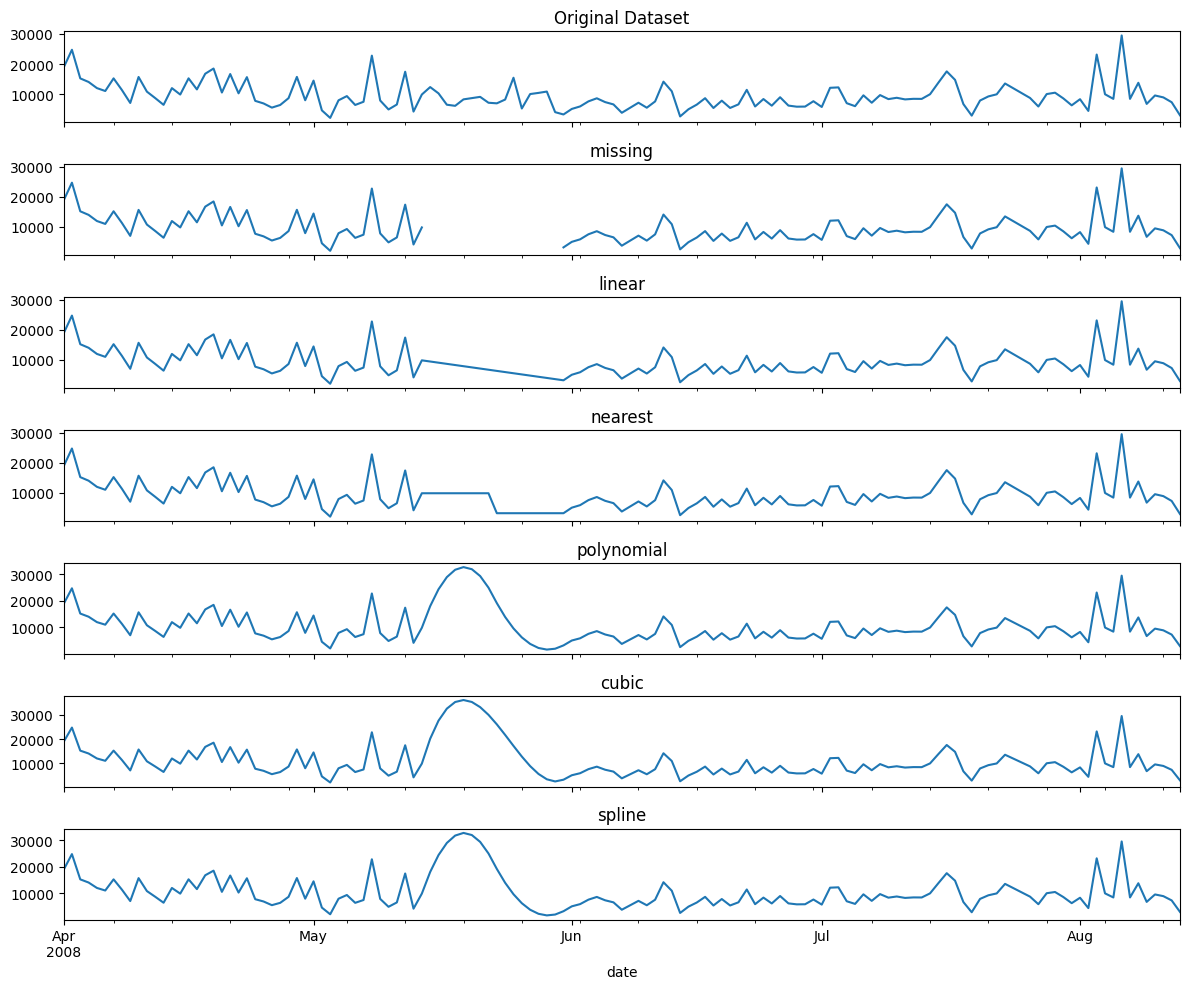

In [113]:
cols = ['clicks', 'linear', 'nearest', 'polynomial', 'cubic', 'spline']
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')

## Analyzing the Interpolation Results

Looking at the RMSE scores and visualizations for both datasets, we can make several key observations:

### CO2 Dataset Results:
- **Linear and Nearest** methods perform best according to RMSE, with values around 0.055
- **Quadratic, Cubic, and Polynomial** methods show higher errors (RMSE ~0.084)
- **Spline** interpolation performs worst with the highest RMSE (~0.188)

This makes sense because the CO2 emissions data shows a relatively consistent trend with gradual changes. Linear interpolation is ideal for such datasets as it avoids introducing unnecessary complexity. The spline method has the highest RMSE because it introduces excessive variation when modeling smooth trends.

### Clickstream Dataset Results:
- **Linear** interpolation performs best (RMSE ~1329)
- **Nearest** interpolation is next best (RMSE ~1706)
- **Polynomial, Cubic, and Spline** methods perform significantly worse (RMSE 5000-6200)

For the Clickstream dataset, the higher-order methods (quadratic, cubic, polynomial, spline) have much higher RMSE scores. This is because these methods tend to exaggerate trends and introduce wild fluctuations, especially in regions with sparse or inconsistent data. The linear method, which simply draws straight lines between known points, avoids this overfitting problem.

### Visual Assessment:
In the visualizations:
- For CO2 data: Linear and nearest methods closely follow the original trend, while polynomial and spline methods introduce unnecessary variations
- For Clickstream data: The polynomial, cubic, and spline methods exaggerate curves, especially in regions with sparse data

### Key Takeaways:
1. **Match the method to the data**: Linear interpolation works best for steady trends (like CO2 emissions), while more complex methods may be better for genuinely non-linear patterns
2. **Beware of overfitting**: Higher-order methods can capture noise rather than the underlying trend
3. **Consider the gap size**: Larger gaps between known values increase the risk of unrealistic interpolations with complex methods

This highlights the trade-off between complexity and accuracy when selecting an interpolation method. While more complex methods can capture non-linear trends, they may overfit in datasets with noise or sparse data. Simpler methods often provide more stable and interpretable results for such cases.

## How Interpolation Works

Interpolation techniques estimate missing values by detecting patterns in neighboring data points to predict what the missing values should be. Each method uses a different mathematical function and approach:

- **Linear interpolation**: Assumes a straight line between two neighboring data points
- **Polynomial interpolation**: Fits a curve of specified order across multiple adjacent points
- **Spline interpolation**: Uses piecewise polynomials for a smoother curve between points
- **Nearest interpolation**: Simply copies the value from the nearest non-missing point
- **Cubic interpolation**: Uses a cubic polynomial (order 3) for smoothly varying curves

In pandas, the `DataFrame.interpolate()` function performs these operations with the default being linear interpolation (`method="linear"`). Additional parameters provide more control over the imputation process.

## Advanced Interpolation Features: Using the limit Parameter

The `limit` parameter allows you to control how many consecutive missing values can be filled. This is particularly useful when you have long stretches of missing data and want to avoid interpolating too far from known values.

Let's first check how many missing values are in our clickstream data:

In [114]:

clicks_missing['clicks'].isna().sum()

np.int64(16)

## Limiting the Number of Consecutive NaN Values to Fill

Let's apply interpolation with a limit of 5, meaning only up to 5 consecutive NaN values will be filled:

In [115]:

example = clicks_missing['clicks'].interpolate(limit=5)

## Checking Remaining Missing Values

Let's see how many NaN values remain after applying interpolation with a limit of 5:


In [116]:

example.isna().sum()

# With a limit of 5, we'd expect 11 NaN values to remain (16 original - 5 filled)

np.int64(11)

## Examining the Original Data with Missing Values

Let's look at a specific date range in the clickstream data to see where the missing values are located:


In [117]:

clicks_missing['clicks']['2008-05-15':].head(10)

date
2008-05-15   NaN
2008-05-16   NaN
2008-05-17   NaN
2008-05-18   NaN
2008-05-19   NaN
2008-05-20   NaN
2008-05-21   NaN
2008-05-22   NaN
2008-05-23   NaN
2008-05-24   NaN
Name: clicks, dtype: float64

## Examining the Data After Limited Interpolation

Now let's look at the same date range after applying interpolation with a limit of 5:

In [118]:


example['2008-05-15':].head(10)

# Notice that only the first 5 missing values have been filled, while the rest remain NaN

date
2008-05-15    9450.0
2008-05-16    9059.0
2008-05-17    8668.0
2008-05-18    8277.0
2008-05-19    7886.0
2008-05-20       NaN
2008-05-21       NaN
2008-05-22       NaN
2008-05-23       NaN
2008-05-24       NaN
Name: clicks, dtype: float64

## Additional Considerations for Interpolation

There are several important points to keep in mind when using interpolation:

1. **Index consideration**: Different interpolation methods handle the index differently:
   - Linear interpolation by default assumes equally spaced data points
   - Methods like 'index', 'time', 'nearest', 'zero', 'slinear', 'quadratic', and 'cubic' take the numerical index values into account

2. **Data integrity**: Using the `limit` parameter helps maintain data integrity by avoiding unreliable interpolations over long sequences of missing data

3. **Method selection**: The best interpolation method depends on:
   - The nature of your data (linear trends vs. non-linear patterns)
   - The distribution of missing values (scattered vs. consecutive)
   - The spacing between data points (regular vs. irregular)

4. **Visualization**: Always visualize the results to ensure the interpolation produces reasonable estimates that align with the expected patterns in your data

## Summary of Interpolation Techniques

Interpolation provides a powerful way to estimate missing values in time series and sequential data. Here's a summary of what we've learned:

### Key Interpolation Methods:
- **Linear**: Simple and effective for data with consistent trends
- **Nearest**: Good for data with discrete or step-like changes
- **Polynomial/Quadratic**: Better for data with gentle curves
- **Cubic/Spline**: Best for data with smooth non-linear patterns

### Performance on Different Datasets:
- For CO2 data (steady trend): Linear and nearest methods worked best
- For Clickstream data (volatile): Linear method showed the lowest error

### Important Parameters:
- **method**: Determines the mathematical function used for interpolation
- **order**: Controls the complexity of polynomial and spline methods
- **limit**: Restricts how many consecutive missing values can be filled

### Best Practices:
1. **Always visualize** the results to ensure they make sense
2. **Start simple** with linear interpolation before trying more complex methods
3. **Use RMSE** to quantitatively compare methods
4. **Consider domain knowledge** about expected patterns in your data
5. **Use limits** when dealing with long stretches of missing data

Remember that interpolation is making educated guesses about missing values. The quality of these guesses depends on how well the chosen method aligns with the underlying patterns in your data. Always validate your results against domain knowledge and, when possible, against a ground truth dataset.

In [119]:
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date', index=True)

In [120]:
clicks_missing.head()

,price,location,clicks
date,,,
2008-04-01,43.155647,2,18784.0
2008-04-02,43.079056,1,24738.0
2008-04-03,43.842609,2,15209.0
2008-04-04,43.312376,1,14018.0
2008-04-05,43.941176,1,11974.0


In [121]:
clicks_missing['clicks']['2008-05-14':]

date
2008-05-14    9841.0
2008-05-15       NaN
2008-05-16       NaN
2008-05-17       NaN
2008-05-18       NaN
               ...  
2008-08-09    6716.0
2008-08-10    9523.0
2008-08-11    8881.0
2008-08-12    7272.0
2008-08-13    2922.0
Name: clicks, Length: 92, dtype: float64

In [122]:
clicks_missing.shape

(135, 3)